En primer lugar se len los datos del archivo, corrigiendo el formato de separacion, de ';' a ','.

In [27]:
import pandas as pd

raw_dataset = pd.read_csv('Calidad_de_agus_2023.csv', delimiter=';')

raw_dataset

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,22/2/2023,2023,Verano,26,24,6.59,7.24,...,<2.0,<30,29,<0.10,<0.005,<0.001,0.87,<0.15,53,Muy deteriorada
1,1,Canal Villanueva y Río Luján,TI001,10/5/2023,2023,otoño,18,12,7.09,7.22,...,<2.0,<30,45.00,<0.10,<0.005,<1.0,2.56,<0.15,39,Extremadamente deteriorada
2,1,Canal Villanueva y Río Luján,TI001,23/8/2023,2023,invierno,16.3,11,8.53,7.27,...,<2.0,<30,38,<0.10,<0.005,<0.001,1.02,<0.15,48,Muy deteriorada
3,1,Canal Villanueva y Río Luján,TI001,14/11/2023,2023,primavera,23,25,4.72,6.57,...,<2.0,<30,24,<0.10,<0.005,<0.001,<10.00,<0.15,42,Extremadamente deteriorada
4,2,Río Lujan y Arroyo Caraguatá,TI006,22/2/2023,2023,Verano,26.8,25,5.94,6.96,...,2.1,<30,24,<0.10,<0.005,<0.001,10.61,0.21,39,Extremadamente deteriorada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,42,Balneario Municipal,BS094,23/8/2023,2023,invierno,12,13,9.41,8.67,...,2.3,66,75,<0.10,<0.005,<0.001,19.25,<0.15,36,Extremadamente deteriorada
165,42,Playa La Balandra,BS093,22/2/2023,2023,Verano,20,23,5.8,7.47,...,3.4,58,17,<0.10,<0.005,<0.001,<0.10,>5.00,no se pudo calcular,NaN
166,42,Playa La Balandra,BS093,10/5/2023,2023,otoño,18,13,5.93,8.35,...,2.10,<30,32.00,<0.10,<0.005,<1.0,54.87,<0.15,36,Extremadamente deteriorada
167,42,Playa La Balandra,BS093,14/11/2023,2023,primavera,20,14,8.22,8.30,...,<2.0,48,110,<0.10,0,<0.001,37.4,<0.15,35,Extremadamente deteriorada


Hacemos un head para ver de que tratan los datos.

In [28]:
raw_dataset.head()

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,22/2/2023,2023,Verano,26,24,6.59,7.24,...,<2.0,<30,29,<0.10,<0.005,<0.001,0.87,<0.15,53,Muy deteriorada
1,1,Canal Villanueva y Río Luján,TI001,10/5/2023,2023,otoño,18,12,7.09,7.22,...,<2.0,<30,45.00,<0.10,<0.005,<1.0,2.56,<0.15,39,Extremadamente deteriorada
2,1,Canal Villanueva y Río Luján,TI001,23/8/2023,2023,invierno,16.3,11,8.53,7.27,...,<2.0,<30,38,<0.10,<0.005,<0.001,1.02,<0.15,48,Muy deteriorada
3,1,Canal Villanueva y Río Luján,TI001,14/11/2023,2023,primavera,23,25,4.72,6.57,...,<2.0,<30,24,<0.10,<0.005,<0.001,<10.00,<0.15,42,Extremadamente deteriorada
4,2,Río Lujan y Arroyo Caraguatá,TI006,22/2/2023,2023,Verano,26.8,25,5.94,6.96,...,2.1,<30,24,<0.10,<0.005,<0.001,10.61,0.21,39,Extremadamente deteriorada


Borramos las columas orden, codigo y año ya que no aportan nada al analisis.

In [29]:
raw_dataset = raw_dataset.drop('orden', axis=1)
raw_dataset = raw_dataset.drop('codigo', axis=1)
raw_dataset = raw_dataset.drop('año', axis=1)


Ahora en busca de nulos por columna.

In [30]:
raw_dataset.isna().sum()

sitios                      0
fecha                       0
campaña                     0
tem_agua                    0
tem_aire                    0
od                          0
ph                          1
olores                      0
color                       0
espumas                     0
mat_susp                    0
colif_fecales_ufc_100ml     0
escher_coli_ufc_100ml       0
enteroc_ufc_100ml           0
nitrato_mg_l                0
nh4_mg_l                    0
p_total_l_mg_l              1
fosf_ortofos_mg_l           0
dbo_mg_l                    1
dqo_mg_l                    0
turbiedad_ntu               0
hidr_deriv_petr_ug_l        0
cr_total_mg_l               0
cd_total_mg_l               0
clorofila_a_ug_l            0
microcistina_ug_l           0
ica                         1
calidad_de_agua            15
dtype: int64

Vemos en cada una de las columnas que valores toman.

In [31]:
#se revisa una por una las columnas
#lo que esta entre corchetes se fue cambiando entre todas las variables para ver que valores aparecen

for idx, val in raw_dataset["od"].value_counts().items():
  print(idx, val)

sin equipo 12
no muestreó 7
no se midió 5
en obra 4
no se muestreó 4
6.3 3
6.4 2
5.4 2
8.53 2
5.94 2
7.60 2
N/R 2
6.33 2
inaccesible 2
5.85 2
5.02 2
7.09 1
6.59 1
5.36 1
2.01 1
5.26 1
4.13 1
2.67 1
3.45 1
5.88 1
3.1 1
1.95 1
6.7 1
6.16 1
6.14 1
6.88 1
2.62 1
4.72 1
7.12 1
7.74 1
7.82 1
5.19 1
4.15 1
8.72 1
8.09 1
6.5 1
5.65 1
5.61 1
5.16 1
6.66 1
6.69 1
3.24 1
6.32 1
7.64 1
2.94 1
8.27 1
4.86 1
6.37 1
6.60 1
5.20 1
8.15 1
6.95 1
6.79 1
7.41 1
4.88 1
4.31 1
5.97 1
6.08 1
5.75 1
2.98 1
5.28 1
2.20 1
5.14 1
5.07 1
8 1
5.57 1
5.58 1
0.6 1
3.03 1
3.33 1
1.2 1
5.22 1
4.85 1
4.99 1
5.24 1
7.9 1
6.20 1
0.96 1
1.22 1
1.99 1
3.02 1
3.22 1
1.1 1
2.64 1
4.45 1
6.82 1
5.55 1
9.88 1
5.70 1
9.3 1
7.23 1
3.55 1
8.4 1
11.49 1
8.11 1
7.13 1
12.62 1
8.28 1
2.68 1
4.24 1
8.44 1
5.48 1
8.57 1
6.13 1
5.63 1
7.43 1
0.2 1
6.24 1
9.05 1
4.76 1
8.99 1
5.92 1
11.70 1
7.51 1
6.65 1
10.88 1
4.53 1
7.53 1
10.02 1
9.78 1
9.41 1
5.8 1
5.93 1
8.22 1
8.96 1


Remplazamos por nulos los valores que no nos interesan, es decir, no nos aportan informacion relevante.

In [32]:
import pandas as pd

# Copiar el dataset
preprocessed_dataset = raw_dataset.copy()

# Lista de valores a reemplazar por pd.NA
valores_a_reemplazar = ['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó',
                        'inaccesible', 'sin muestra', 'envase sin muestra', 'falto un frasco',
                        'Dato atípico', 'no se pudo calcular', 'N/R', 'no funcionó', '-', 'N/A', '', ' ']

# Lista de columnas a las que se les debe aplicar el reemplazo
columnas_a_procesar = [
    'tem_agua', 'tem_aire', 'od', 'ph', 'olores', 'color', 'espumas', 'mat_susp', 
    'colif_fecales_ufc_100ml', 'escher_coli_ufc_100ml', 'enteroc_ufc_100ml', 
    'nitrato_mg_l', 'nh4_mg_l', 'p_total_l_mg_l', 'fosf_ortofos_mg_l', 
    'dbo_mg_l', 'dqo_mg_l', 'turbiedad_ntu', 'hidr_deriv_petr_ug_l', 'cr_total_mg_l',
    'cd_total_mg_l', 'clorofila_a_ug_l', 'microcistina_ug_l', 'ica', 'calidad_de_agua'
]

# Recorrer todas las columnas y aplicar el reemplazo
for columna in columnas_a_procesar:
    preprocessed_dataset[columna] = preprocessed_dataset[columna].replace(valores_a_reemplazar, pd.NA)


Ahora vamos a borrar aquellas filas que quedaron con muchos nulos, ya que no nos van a servir para el analisis. Estas filas borradas son aquellas con mas de 23 valores nulos, que corresponden a las muestras donde no se realizaron observaciones.

In [33]:

preprocessed_dataset = preprocessed_dataset.dropna(thresh=len(preprocessed_dataset.columns) - 23)

Luego definimos las columnas que van a ser de tipo cuantitativos y de fecha, eliminando los simbolos "<" o ">" en los valores que los porten.

In [34]:
columnas_a_convertir = ['tem_agua', 'tem_aire', 'od', 'ph', 'colif_fecales_ufc_100ml',
                         'escher_coli_ufc_100ml', 'enteroc_ufc_100ml', 'nitrato_mg_l', 'nh4_mg_l',
                         'p_total_l_mg_l', 'fosf_ortofos_mg_l', 'dbo_mg_l', 'dqo_mg_l', 'turbiedad_ntu',
                         'cr_total_mg_l', 'cd_total_mg_l', 'clorofila_a_ug_l',
                         'microcistina_ug_l', 'ica']

for col in columnas_a_convertir:
    preprocessed_dataset[col] = preprocessed_dataset[col].str.replace('<', '').str.replace('>', '')
    preprocessed_dataset[col] = pd.to_numeric(preprocessed_dataset[col])

preprocessed_dataset['fecha'] = pd.to_datetime(preprocessed_dataset['fecha'], format="%d/%m/%Y")

Transformamos el tipo de dato de determinadas columnas para poder trabajar con las variables cualitativas.

In [35]:
#Transformacion campaña
preprocessed_dataset['campaña']=preprocessed_dataset['campaña'].replace(['Verano','otoño','invierno','primavera'],['0','1','2','3'])

#transformacion olores, color, espumas,mat_susp
preprocessed_dataset['olores']=preprocessed_dataset['olores'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['color']=preprocessed_dataset['color'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['espumas']=preprocessed_dataset['espumas'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['mat_susp']=preprocessed_dataset['mat_susp'].replace(['Ausencia','Presencia'],['0','1'])

#transformacion calidad_de_agua
preprocessed_dataset['calidad_de_agua']=preprocessed_dataset['calidad_de_agua'].replace(['Muy deteriorada','Muy deteriorada ','Extremadamente deteriorada'],['0','0','1'])

columnas_cualitativas = ['campaña', 'olores', 'color', 'espumas', 'mat_susp', 'calidad_de_agua']
preprocessed_dataset[columnas_cualitativas] = preprocessed_dataset[columnas_cualitativas].apply(pd.to_numeric, errors='coerce')

Analizamos el porcentaje de nulos en cada columna para ver si las eliminabamos. Como en ninguna de las columnas hay presencia de nulos mayor o igual al 60% las conservamos.

In [36]:
columnas_totales = columnas_a_convertir.copy()
columnas_totales.extend(columnas_cualitativas)

for col in columnas_totales:
    if ((preprocessed_dataset[col].isna().sum() / len(preprocessed_dataset[col]))*100 >= 60):
        print(col)

De acuerdo a la columna, realizamos imputaciones con la tecnica de los n vecinos mas cercanos, eligiendo los dos mas cercanos, para suprimir los valores nulos restantes.

In [37]:
preprocessed_dataset['hidr_deriv_petr_ug_l'].value_counts()

hidr_deriv_petr_ug_l
<0.10    150
Name: count, dtype: int64

Notamos que solo hay un tipo de valor en la columna hidr_deriv_petr_ug_l, por lo que la quitamos al ser constante a lo largo de las mediciones.

In [38]:
preprocessed_dataset = preprocessed_dataset.drop('hidr_deriv_petr_ug_l', axis=1)

No sabemos si esto es correcto al no haber analizado los mecanismos de datos faltantes, por desconcer el dominio del problema.

In [39]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 2, weights = "uniform")


preprocessed_dataset_imputado = preprocessed_dataset[columnas_totales]
dataset_imputado = imputer.fit_transform(preprocessed_dataset_imputado)

preprocessed_dataset[columnas_totales] = dataset_imputado


Hipótesis 5: la cantidad de toxinas esta condicionada por diversos factores:

Una de las hipótesis planteadas es que la cantidad de toxinas producidas por las algas podría estar influenciada por varios factores ambientales, tales como el pH, la temperatura del agua (tem_agua), la concentración de nitratos (nitrato_mg_l), el fósforo total (p_total_l_mg_l), la concentración de microcistinas (microcistina_ug_l), el pH y la turbidez (turbiedad_ntu). Estas variables podrían ser afectadas por la presencia de toxinas, o bien, podrían influir en el crecimiento de las algas, lo que, a su vez, impactaría la cantidad de toxinas producidas.

Como primer paso para explorar esta hipótesis, se realiza un análisis descriptivo de los datos utilizando el método describe(), con el fin de obtener una visión general de las características de las variables involucradas y su distribución.

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




# Atributos relevantes
atributos = ['tem_agua', 'nitrato_mg_l', 'p_total_l_mg_l', 'microcistina_ug_l','ph','turbiedad_ntu']


# 1. Estadísticas descriptivas
estadisticas = preprocessed_dataset[atributos].describe()
print(estadisticas)



         tem_agua  nitrato_mg_l  p_total_l_mg_l  microcistina_ug_l  \
count  151.000000    151.000000      151.000000         151.000000   
mean     0.441284      0.171287        0.135662           0.111914   
std      0.249158      0.236503        0.168938           0.295500   
min      0.000000      0.000000        0.000000           0.000000   
25%      0.287356      0.030952        0.036667           0.000000   
50%      0.373563      0.088095        0.083333           0.000000   
75%      0.632184      0.202381        0.156667           0.002062   
max      1.000000      1.000000        1.000000           1.000000   

               ph  turbiedad_ntu  
count  151.000000     151.000000  
mean     0.395048       0.076626  
std      0.136271       0.095924  
min      0.000000       0.000000  
25%      0.334297       0.032859  
50%      0.377649       0.051503  
75%      0.431599       0.098112  
max      1.000000       1.000000  


Analizamos la distribucion.

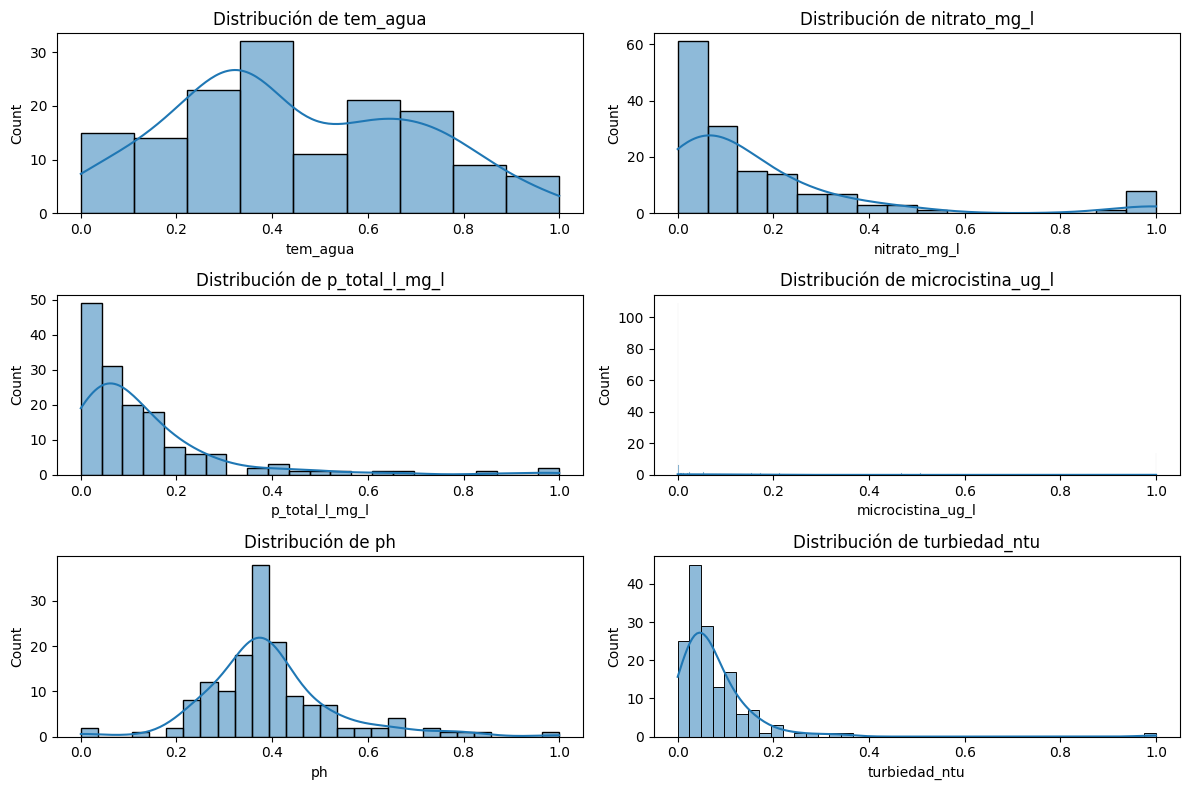

In [121]:


# Seleccionamos solo las columnas numéricas que queremos estandarizar
# 2. Histogramas para ver la distribución de cada atributo
plt.figure(figsize=(12, 8))
for i, atributo in enumerate(atributos, 1):
    plt.subplot(3, 2, i)
    sns.histplot(preprocessed_dataset[atributo], kde=True)
    plt.title(f'Distribución de {atributo}')
plt.tight_layout()
plt.show()



Analizamos si existen valores atipicos.

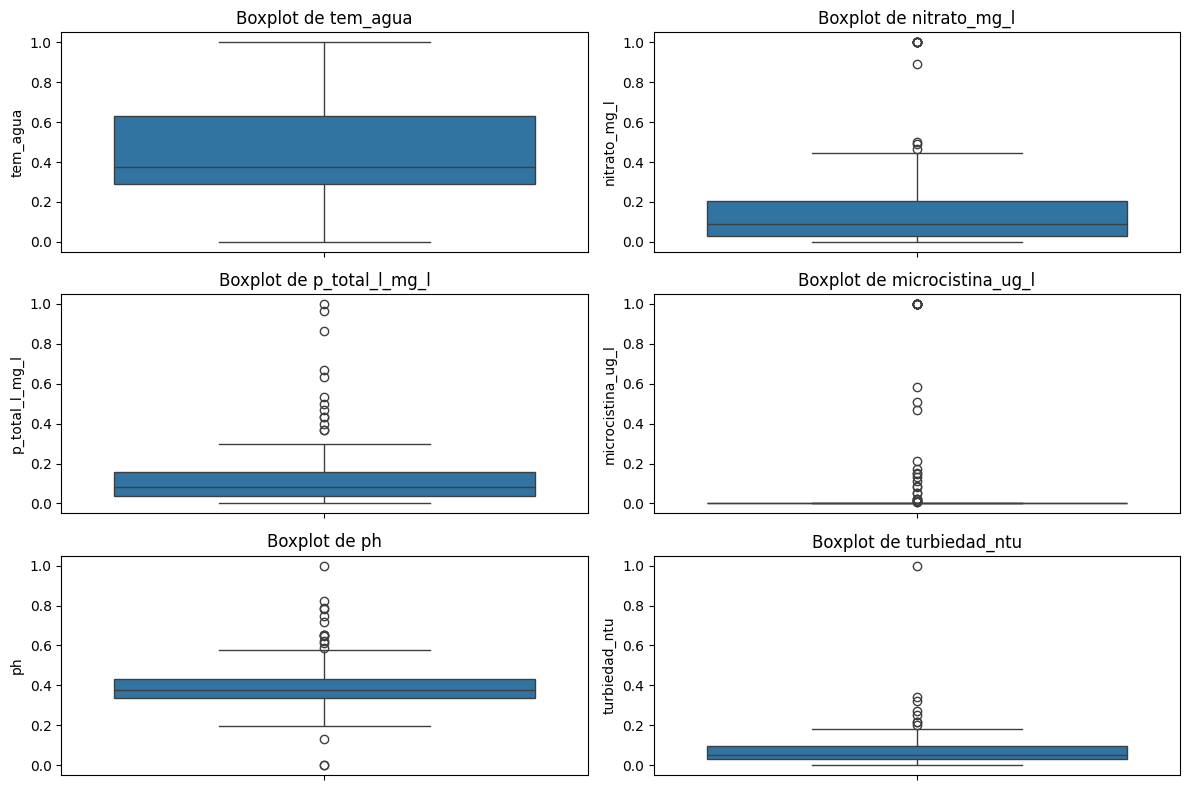

In [123]:

plt.figure(figsize=(12, 8))
for i, atributo in enumerate(atributos, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=preprocessed_dataset, y=atributo)
    plt.title(f'Boxplot de {atributo}')
plt.tight_layout()
plt.show()



Ahora analicemos las correlaciones de las variables para ver si a priori existe alguna relacion lineal.

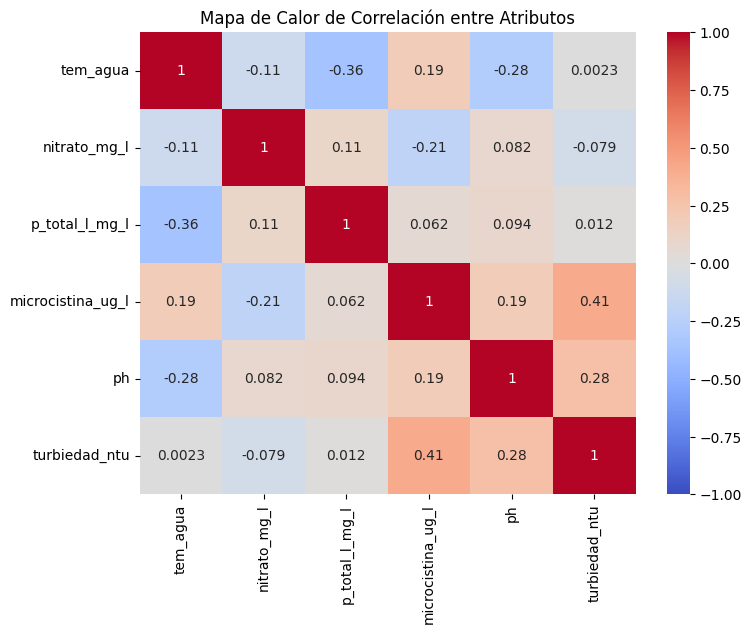

In [124]:
plt.figure(figsize=(8, 6))
sns.heatmap(preprocessed_dataset[atributos].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor de Correlación entre Atributos')
plt.show()


Vemos que las correlaciones entre las variables no es muy alta, algo decepcionante, pero podria ser gracias a que comparamos de a pares y que un conjunto de ellas afecte a otra, por lo que podemos aplicar PCA para proyectar a un espacio de dos dimensiones para posteriormente comparar con la variable microsistina.

Antes de PCA: (151, 5)
Después de PCA: (151, 2)


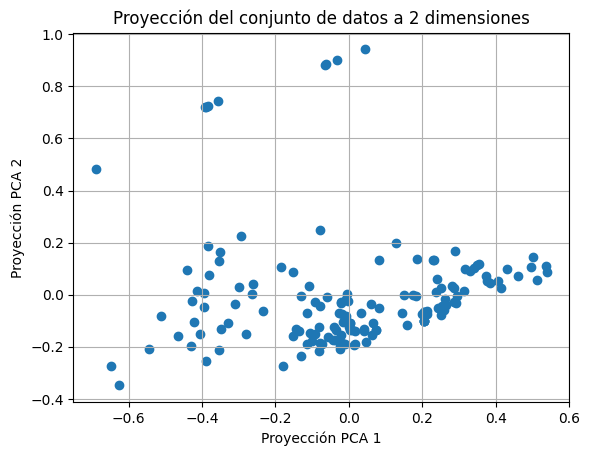

In [127]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
preprocessed_dataset_normalizado= preprocessed_dataset[atributos].copy()
preprocessed_dataset_normalizado[atributos]= scaler.fit_transform(preprocessed_dataset_normalizado[atributos])

data_sin_micro= preprocessed_dataset_normalizado.drop('microcistina_ug_l', axis=1)


pca = PCA(n_components=2, whiten=False)
# transforme los datos, para ya reducir a dos dimensiones
principalComponents = pca.fit_transform(data_sin_micro)
# imprimimos los tamaños antes y después
print('Antes de PCA: {}'.format(data_sin_micro.shape))
print('Después de PCA: {}'.format(principalComponents.shape))

# graficamos los datos. el color de cada punto representa el valor de la casa
plt.scatter(principalComponents[:,0], principalComponents[:,1])
plt.grid(True)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.show()

Ahora habiendo reducido la dimension podemos comparar con los valores que toma la variable microsistina.

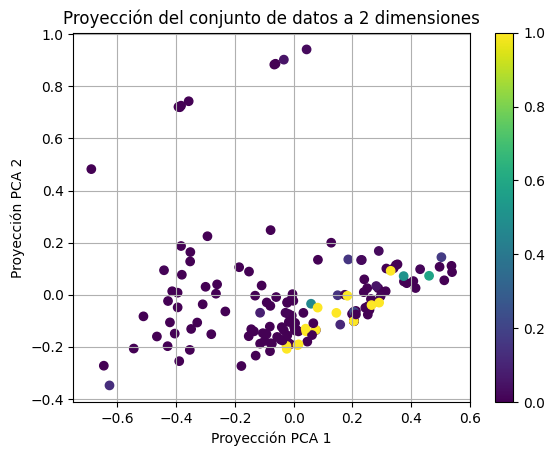

In [129]:

plt.scatter(principalComponents[:,0], principalComponents[:,1], c=preprocessed_dataset_normalizado["microcistina_ug_l"], cmap='viridis')
plt.grid(True)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.colorbar()
plt.show()


Los puntos con valores más altos de microcistina (en amarillo) están distribuidos de manera dispersa en el gráfico, con una leve tendencia a concentrarse en la parte derecha e inferior. Sin embargo, no se observa una separación clara entre los valores altos y bajos de microcistina en el espacio reducido de PCA. Esto sugiere que las variables utilizadas en el análisis podrían no estar fuertemente relacionadas con la concentración de microcistina, o bien que existen otros factores adicionales que también están influyendo en su variación. Por lo tanto, esta hipótesis no se puede confirmar y será descartada.

Hipótesis 6: Los niveles elevados de demanda biológica de oxígeno (dbo mg l) están correlacionados con altos niveles de nutrientes como nitrato, fósforo y amonio, ademas de que los indicadores de materia fecal contribuye a esta demanda de oxigeno ya que proliferan los microorganismos.
Como primer paso podemos ver las estadísticas descriptivas.

In [166]:
atributos = ['nitrato_mg_l', 'p_total_l_mg_l','dbo_mg_l','nh4_mg_l','escher_coli_ufc_100ml', 'colif_fecales_ufc_100ml', 'enteroc_ufc_100ml']

estadisticas = preprocessed_dataset[atributos].describe()
print(estadisticas)

       nitrato_mg_l  p_total_l_mg_l    dbo_mg_l    nh4_mg_l  \
count    151.000000      151.000000  151.000000  151.000000   
mean       0.171287        0.135662    4.223179    1.949272   
std        0.236503        0.168938    3.548398    3.022356   
min        0.000000        0.000000    2.000000    0.050000   
25%        0.030952        0.036667    2.000000    0.315000   
50%        0.088095        0.083333    3.200000    0.780000   
75%        0.202381        0.156667    4.600000    1.900000   
max        1.000000        1.000000   24.000000   18.000000   

       escher_coli_ufc_100ml  colif_fecales_ufc_100ml  enteroc_ufc_100ml  
count             151.000000               151.000000         151.000000  
mean             5006.048675              7201.072185        1480.651258  
std             16552.262770             16527.608900        3111.197351  
min                 1.500000                 1.000000           1.000000  
25%               310.000000               400.000000    

Como se puede observar la diferencia de los valores que toma nitrato con respecto a fosforo y microcistina es muy grande, por lo que mas adelante tendremos que estandarizar o normalizar los datos dependiendo la distribucion que sigan.
A continuacion estudiamos mediante graficos que distribucion siguen.

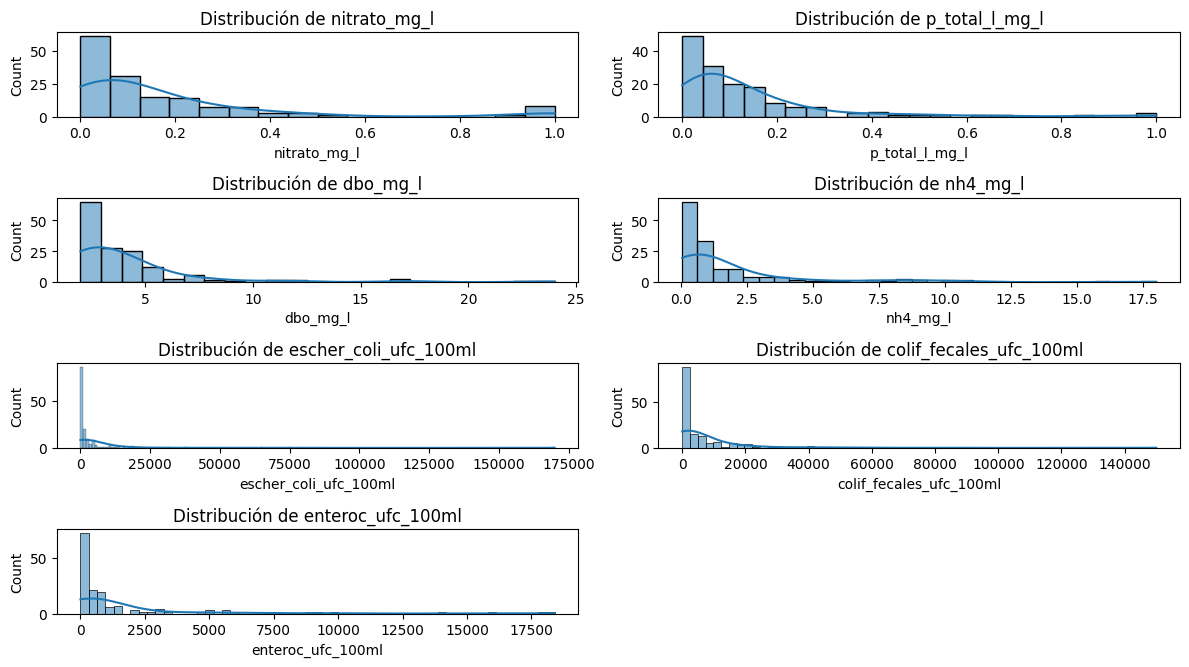

In [168]:
# 2. Histogramas para ver la distribución de cada atributo
plt.figure(figsize=(12, 8))
for i, atributo in enumerate(atributos, 1):
    plt.subplot(5, 2, i)
    sns.histplot(preprocessed_dataset[atributo], kde=True)
    plt.title(f'Distribución de {atributo}')
plt.tight_layout()
plt.show()

Vemos que no tienen una distribucion normal, ahora vamos a analizar los outlier ya que esto influye en la eleccion de herramientas para el analisis.

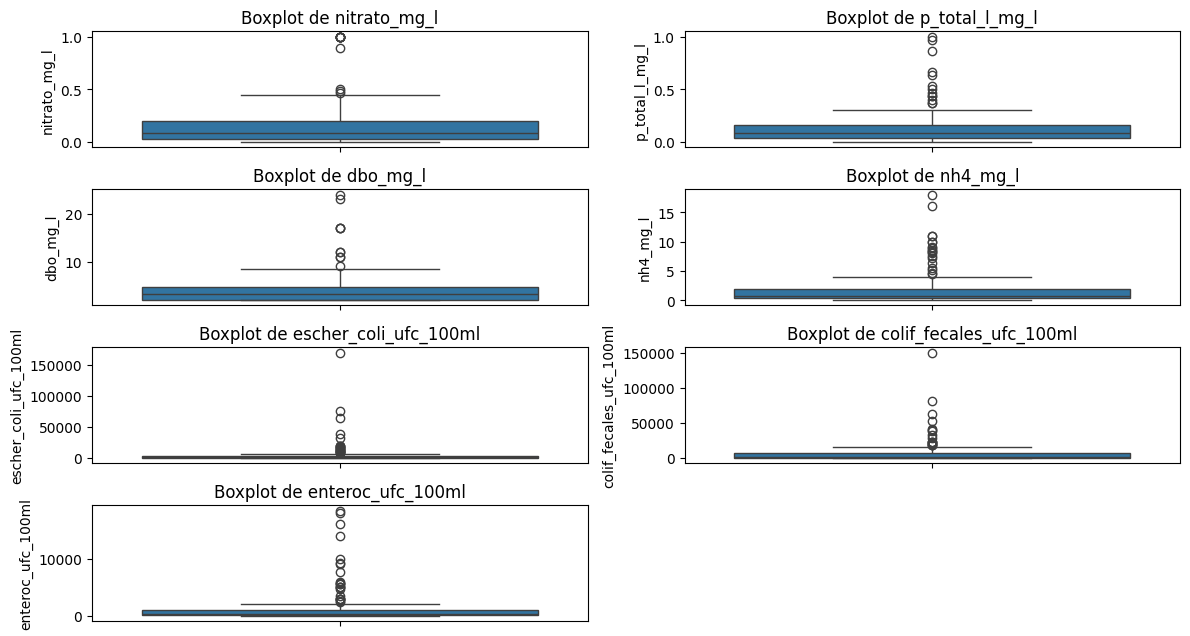

In [170]:
plt.figure(figsize=(12, 8))
for i, atributo in enumerate(atributos, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(data=preprocessed_dataset, y=atributo)
    plt.title(f'Boxplot de {atributo}')
plt.tight_layout()
plt.show()

Se pueden observar bastantes valores atipicos que no necesariamente son errores en la medicion.
Posteriormente vamos a ver si entre estas variables existe alguna relacion lineal, la cual nos motive a seguir por aca.

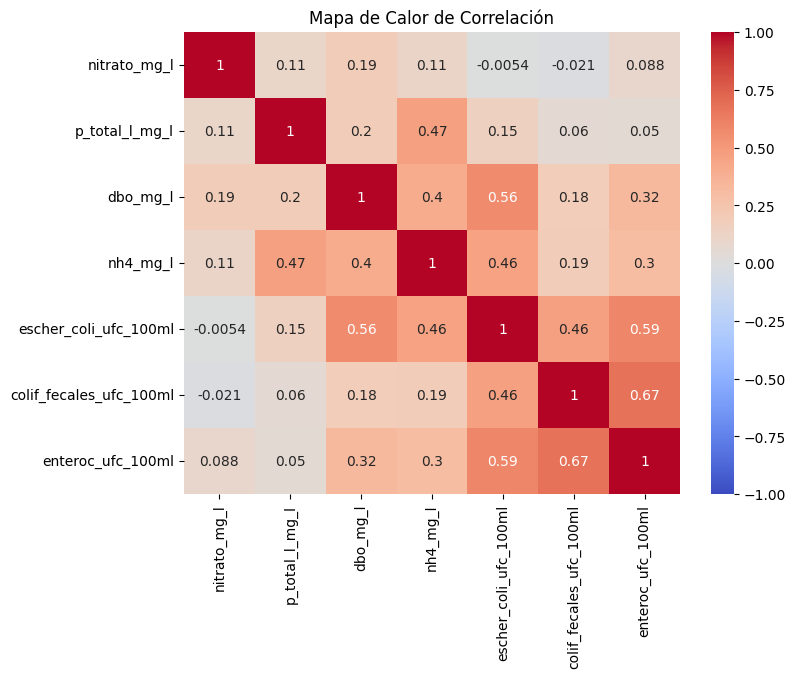

In [178]:
plt.figure(figsize=(8, 6))
sns.heatmap(preprocessed_dataset[atributos].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor de Correlación')
plt.show()

Antes de PCA: (151, 6)
Después de PCA: (151, 2)


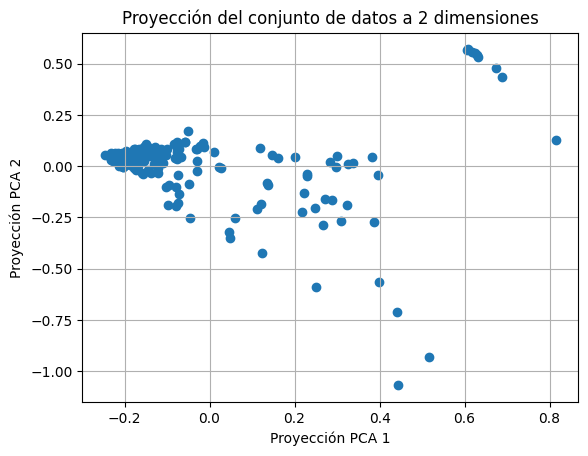

In [176]:
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
preprocessed_dataset_normalizado= preprocessed_dataset[atributos].copy()
preprocessed_dataset_normalizado[atributos]= scaler.fit_transform(preprocessed_dataset_normalizado[atributos])


data_sin_nh4= preprocessed_dataset_normalizado.drop('dbo_mg_l', axis=1)

pca = PCA(n_components=2, whiten=False)
# transforme los datos, para ya reducir a dos dimensiones
principalComponents = pca.fit_transform(data_sin_nh4)
# imprimimos los tamaños antes y después
print('Antes de PCA: {}'.format(data_sin_nh4.shape))
print('Después de PCA: {}'.format(principalComponents.shape))

# graficamos los datos. el color de cada punto representa el valor de la casa
plt.scatter(principalComponents[:,0], principalComponents[:,1])
plt.grid(True)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.show()

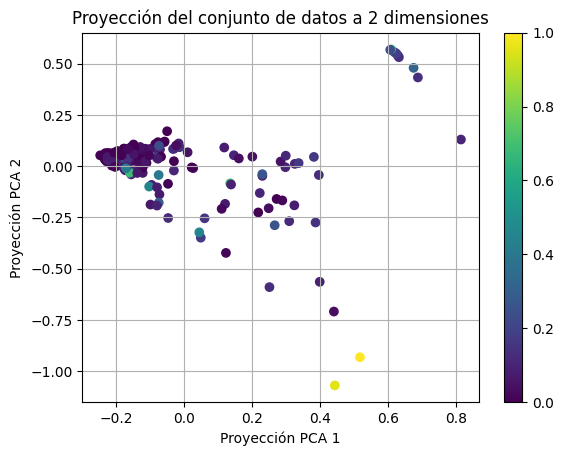

In [174]:


plt.scatter(principalComponents[:,0], principalComponents[:,1], c=preprocessed_dataset_normalizado["dbo_mg_l"], cmap='viridis')
plt.grid(True)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.colorbar()
plt.show()

Como se puede observar en el grafico, no existe algun patron que nos motive a seguir con esta hipotesis, por lo que queda descartada.